# "Anticipez les besoins en consommation électrique de bâtiments"
_Notebook_

## 0 Preliminaries

### 0.0 Importing Packages and Modules

Checking whether the notebook is on Colab or PC

In [60]:
import sys
is_colab = 'google.colab' in sys.modules
is_colab, sys.executable

(True, '/usr/bin/python3')

Mounting my Drive if on colab

In [61]:
if is_colab==True:
    from google.colab import files, output, drive
    drive.mount('/gdrive')
    %cd /gdrive
    print("You're on Google Colab")
else:
    print("You're on a PC")

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive
You're on Google Colab


Noticing user about files that has to be in the current working directory.

In [62]:
def file_required(file_name):
    if os.path.exists(os.getcwd()+"/"+file_name):
        print("OK, loading "+file_name+"\
                           from the current working directory ...")
    else:
        print("Please, put "+file_name+"\
                           in the current working directory")

Installations and importations required for Google Colab version.

In [63]:
# !pip freeze > requirements.txt

In [64]:
# !pip install mlxtend==0.17.2

In [65]:
import os

if is_colab==True:
    if os.getcwd()!='/gdrive/My Drive/--DATA SCIENCE/PROJET4':
        os.chdir('My Drive/--DATA SCIENCE/PROJET4')
    !pip install -r requirements.txt
else:
    # make sure 'P4_functions.py' is in the current working directory
    file_required('/P4_functions.py')
    file_required('requirements.txt')
    !pip install -r requirements.txt

In [66]:
from P4_functions import *

Importation of modules and packages. 

In [67]:
import io
# import re
import simplejson as json
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor']='w'
# from ipywidgets import interact, interact_manual
import warnings
warnings.filterwarnings('ignore')

import missingno as msno
import ppscore as pps

import dill

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_pca_correlation_graph

import category_encoders as ce

from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.linear_model import *
from sklearn import metrics

Setting pandas display options

In [68]:
dictPdSettings = {'display.max_rows': 500, 'display.width': 100,
                    'display.max_colwidth': 100,
                    'display.float_format': lambda x: '%.2f' % x}
for k,v in dictPdSettings.items():
  pd.set_option(k,v)

To play audio text-to-speech during execution.

In [69]:
from IPython.display import Audio
from gtts import gTTS

def speak(text, lang='en'):
    with io.BytesIO() as f:
        gTTS(text=text, lang=lang).write_to_fp(f)
        f.seek(0)
        return Audio(f.read(), autoplay=True)

In [70]:
plot_enabled = False
save_enabled = False

In [71]:
speak('Packages and modules successfully imported')

### 0.1 Importing the dataset

In [72]:
if is_colab==True:
    path_csv_1 = 'DATA/2015-building-energy-benchmarking.csv' 
    path_csv_2 = 'DATA/2016-building-energy-benchmarking.csv'
    path_json_1 = 'DATA/datasets_34249_1051576_socrata_metadata_2015-building-energy-benchmarking.json'
    path_json_2 = 'DATA/datasets_34249_1051576_socrata_metadata_2016-building-energy-benchmarking.json'
    # Importing database from my Drive
    print("2. Try to import in notebook from myDrive...")
else:
    path_csv_1 = '../DATA/2015-building-energy-benchmarking.csv'
    path_csv_2 = '../DATA/2016-building-energy-benchmarking.csv'
    # Importing database from a DATA directory
    print("2. Try to import in notebook from PC ('DATA')")

df_2015 = pd.read_csv(path_csv_1, sep=',',
                 low_memory=True, encoding ='utf-8')
df_2016 = pd.read_csv(path_csv_2, sep=',',
                 low_memory=True, encoding ='utf-8')
# json_str_2015 = pd.read_csv(path_json_1, sep=',',
#                  low_memory=True, encoding ='utf-8')


print("-----> importation of .csv  and .jsonfiles in notebook OK")

2. Try to import in notebook from myDrive...
-----> importation of .csv  and .jsonfiles in notebook OK


Importing metadata in python dictionnary

In [73]:
json_dict_2015 = json.loads(open(path_json_1, "rt").read())
json_dict_2016 = json.loads(open(path_json_2, "rt").read())

In [74]:
# df_2015.info(memory_usage='deep')

In [75]:
# df_2016.info(memory_usage='deep')

In [76]:
speak('Datasets successfully imported')

### 0.2 First Overview

First description of the data

In [77]:
# desc_2015 = df_2015.describe(include='all')
# desc_2015

In [78]:
# desc_2016 = df_2016.describe(include='all')
# desc_2016

Checking the columns

In [79]:
# for i, c in enumerate(df_2015.columns):
#     print('\n'+c if i % 3 == 0 else c, end=' | ')
# print('\n')
# for i, c in enumerate(df_2016.columns):
#     print('\n'+c if i % 3 == 0 else c, end=' | ')

Printing total nb and percentage of null

In [80]:
print_null_pct(df_2015)
print_null_pct(df_2016)

nb of null:  26512 
pct of null:  16.9
nb of null:  19952 
pct of null:  12.8


Visualizing missing data for each dataframes

In [81]:
# plot_export_missing(df_2015, df_2015.columns, 'missing_vals_2015.png',
#                     'Overview of missing data in benchmarking_2015\n(before cleaning)',
#                     shorten_label=True)

In [82]:
# plot_export_missing(df_2016, df_2016.columns, 'missing_vals_2016.png',
#                     'Overview of missing data in benchmarking_2016\n(before cleaning)',
#                     shorten_label=True)

In [83]:
speak('Description overview done')

## 1 Data Cleaning

### 1.1 Merging 2015 and 2016 data

#### Checking available columns

Printing the list of the shared columns in df_2015 and df_2016, then only in df_2015 and then only in df_2016.

In [84]:
col_list = [c for c in df_2016.columns if c in df_2015.columns]
print("both in 2015 and 2016 ({}):".format(len(col_list)))
for i, c in enumerate(col_list,1):
    if i%6==1: print('')
    print(c, end=' | ')

col_list_2015 = [c for c in df_2015.columns if c not in df_2016.columns]
print("\n\nonly in 2015 ({}):".format(len(col_list_2015)))
for i, c in enumerate(col_list_2015,1):
    if i%6==1: print('')
    print(c, end=' | ')

col_list_2016 = [c for c in df_2016.columns if c not in df_2015.columns]
print("\n\nonly in 2016 ({}):".format(len(col_list_2016)))
for i, c in enumerate(col_list_2016,1):
    if i%6==1: print('')
    print(c, end=' | ')

both in 2015 and 2016 (37):

OSEBuildingID | DataYear | BuildingType | PrimaryPropertyType | PropertyName | TaxParcelIdentificationNumber | 
CouncilDistrictCode | Neighborhood | YearBuilt | NumberofBuildings | NumberofFloors | PropertyGFATotal | 
PropertyGFAParking | PropertyGFABuilding(s) | ListOfAllPropertyUseTypes | LargestPropertyUseType | LargestPropertyUseTypeGFA | SecondLargestPropertyUseType | 
SecondLargestPropertyUseTypeGFA | ThirdLargestPropertyUseType | ThirdLargestPropertyUseTypeGFA | YearsENERGYSTARCertified | ENERGYSTARScore | SiteEUI(kBtu/sf) | 
SiteEUIWN(kBtu/sf) | SourceEUI(kBtu/sf) | SourceEUIWN(kBtu/sf) | SiteEnergyUse(kBtu) | SiteEnergyUseWN(kBtu) | SteamUse(kBtu) | 
Electricity(kWh) | Electricity(kBtu) | NaturalGas(therms) | NaturalGas(kBtu) | DefaultData | ComplianceStatus | 
Outlier | 

only in 2015 (10):

Location | OtherFuelUse(kBtu) | GHGEmissions(MetricTonsCO2e) | GHGEmissionsIntensity(kgCO2e/ft2) | Comment | 2010 Census Tracts | 
Seattle Police Department M

#### Checking the sum of the energy sub-columns.

In [85]:
sel_cols_2015 = ['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)',
                 'OtherFuelUse(kBtu)']
sel_cols_2016 = ['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']

In 2015:

In [86]:
res_2015 = pd.concat([(df_2015[sel_cols_2015]==0).sum(),
           (df_2015[sel_cols_2015]!=0).sum(),
           (df_2015[sel_cols_2015].isna()).sum()], axis=1)
res_2015.columns = ['==0', '!=0', 'is NaN']
res_2015

,==0,!=0,is NaN
SteamUse(kBtu),3200,140,10
Electricity(kBtu),2,3338,10
NaturalGas(kBtu),1256,2084,10
OtherFuelUse(kBtu),3313,27,10


0.9999986306847124 1.314227760703153
0.6958013685145714 1.314227760703153


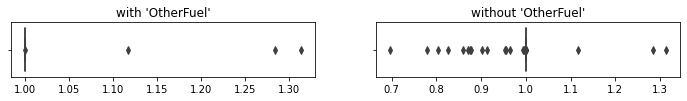

In [87]:
res_2015_1 = df_2015[sel_cols_2015].sum(axis=1)/df_2015['SiteEnergyUse(kBtu)']
res_2015_2 = df_2015[sel_cols_2016].sum(axis=1)/df_2015['SiteEnergyUse(kBtu)']
print(min(res_2015_1), max(res_2015_1))
print(min(res_2015_2), max(res_2015_2))
fig, axs = plt.subplots(1,2)
fig.set_size_inches(12,1)
sns.boxplot(res_2015_1, ax=axs[0])
axs[0].set_title("with 'OtherFuel'")
sns.boxplot(res_2015_2, ax=axs[1])
axs[1].set_title("without 'OtherFuel'")
plt.show()

In 2016:

In [88]:
res_2016 = pd.concat([(df_2016[sel_cols_2016]==0).sum(),
           (df_2016[sel_cols_2016]!=0).sum(),
           (df_2016[sel_cols_2016].isna()).sum()], axis=1)
res_2016.columns = ['==0', '!=0', 'is NaN']
res_2016

,==0,!=0,is NaN
SteamUse(kBtu),3237,139,9
Electricity(kBtu),14,3362,9
NaturalGas(kBtu),1258,2118,9


-0.3367616358600123 inf


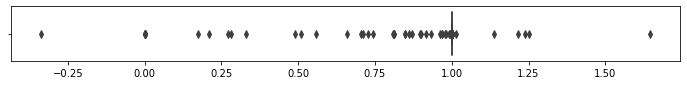

In [89]:
sel_cols_2016 = ['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']
res_2016 = df_2016[sel_cols_2016].sum(axis=1)/df_2016['SiteEnergyUse(kBtu)']
print(min(res_2016), max(res_2016))
fig, ax = plt.subplots(1)
fig.set_size_inches(12,1)
sns.boxplot(res_2016, ax=ax)
plt.show()

#### Dropping, renaming, creating to harmonize the dataframes

Dropping useless columns missing in one of the two datasets

In [90]:
df_2015 = df_2015.drop(columns=['City Council Districts', 'SPD Beats',
        'Seattle Police Department Micro Community Policing Plan Areas',
        '2010 Census Tracts'])
df_2016 = df_2016.drop(columns=['City', 'State'])

Renaming the columns to harmonize 2015 and 2016 datasets.

In [91]:
rename_2015 = {'Comment': 'Comments', 'Zip Codes': 'ZipCode',
               'GHGEmissions(MetricTonsCO2e)': 'TotalGHGEmissions',
               'GHGEmissionsIntensity(kgCO2e/ft2)': 'GHGEmissionsIntensity'}
df_2015 = df_2015.rename(columns=rename_2015)

Splitting the 'location' column in the 2015 dataset to recreate 'Latitude', Longitude', 'Address' and 'ZipCode'.

NB: the original 'Zip Codes' column in the 2015 dataset seem to contain wrong zipcode. We take the valid zipcode from the 'Location' column to get valid values that we put in a new ZipCode column.

In [92]:
df_2015['Latitude'] = df_2015['Location'].apply(lambda x: eval(x)['latitude']).astype('float64')
df_2015['Longitude'] = df_2015['Location'].apply(lambda x: eval(x)['longitude']).astype('float64')
df_2015['HumanAddress'] = df_2015['Location'].apply(lambda x: eval(x)['human_address'])
df_2015['Address'] = df_2015['HumanAddress'].apply(lambda x: eval(x)['address'])
df_2015['ZipCode'] = df_2015['HumanAddress'].apply(lambda x: eval(x)['zip'])
df_2015 = df_2015.drop(columns=['Location', 'HumanAddress'])

Creating the missing column in 2016.

In [93]:
df_2016['OtherFuelUse(kBtu)'] = pd.Series([], dtype='float64')

Harmonizing the categories and the strings formatting.

In [94]:
df_2015['DefaultData'] = df_2015['DefaultData'].map({'No': False, 'Yes': True}).astype('bool')
df_2016['PropertyName'] = df_2016['PropertyName'].map(str.upper)

#### Merging the dataframes

Checking columns before we concatenate the two dataframes.

In [95]:
col_list = [c for c in df_2016.columns if c in df_2015.columns]
print("both in 2015 and 2016 ({}):".format(len(col_list)))
for i, c in enumerate(col_list,1):
    if i%6==1: print('')
    print(c, end=' | ')

col_list_2015 = [c for c in df_2015.columns if c not in df_2016.columns]
print("\n\nonly in 2015 ({}):".format(len(col_list)))
for i, c in enumerate(col_list_2015,1):
    if i%6==1: print('')
    print(c, end=' | ')

col_list_2016 = [c for c in df_2016.columns if c not in df_2015.columns]
print("\n\nonly in 2016 ({}):".format(len(col_list)))
for i, c in enumerate(col_list_2016,1):
    if i%6==1: print('')
    print(c, end=' | ')

both in 2015 and 2016 (45):

OSEBuildingID | DataYear | BuildingType | PrimaryPropertyType | PropertyName | Address | 
ZipCode | TaxParcelIdentificationNumber | CouncilDistrictCode | Neighborhood | Latitude | Longitude | 
YearBuilt | NumberofBuildings | NumberofFloors | PropertyGFATotal | PropertyGFAParking | PropertyGFABuilding(s) | 
ListOfAllPropertyUseTypes | LargestPropertyUseType | LargestPropertyUseTypeGFA | SecondLargestPropertyUseType | SecondLargestPropertyUseTypeGFA | ThirdLargestPropertyUseType | 
ThirdLargestPropertyUseTypeGFA | YearsENERGYSTARCertified | ENERGYSTARScore | SiteEUI(kBtu/sf) | SiteEUIWN(kBtu/sf) | SourceEUI(kBtu/sf) | 
SourceEUIWN(kBtu/sf) | SiteEnergyUse(kBtu) | SiteEnergyUseWN(kBtu) | SteamUse(kBtu) | Electricity(kWh) | Electricity(kBtu) | 
NaturalGas(therms) | NaturalGas(kBtu) | DefaultData | Comments | ComplianceStatus | Outlier | 
TotalGHGEmissions | GHGEmissionsIntensity | OtherFuelUse(kBtu) | 

only in 2015 (45):


only in 2016 (45):


Creating a new dataframe with data of 2015 and 2016

In [96]:
df = pd.concat([df_2015, df_2016]).sort_values('OSEBuildingID')

In [97]:
df['DataYear'] = df['DataYear'].apply(str)

Visualizing missing data for the merged dataframe.

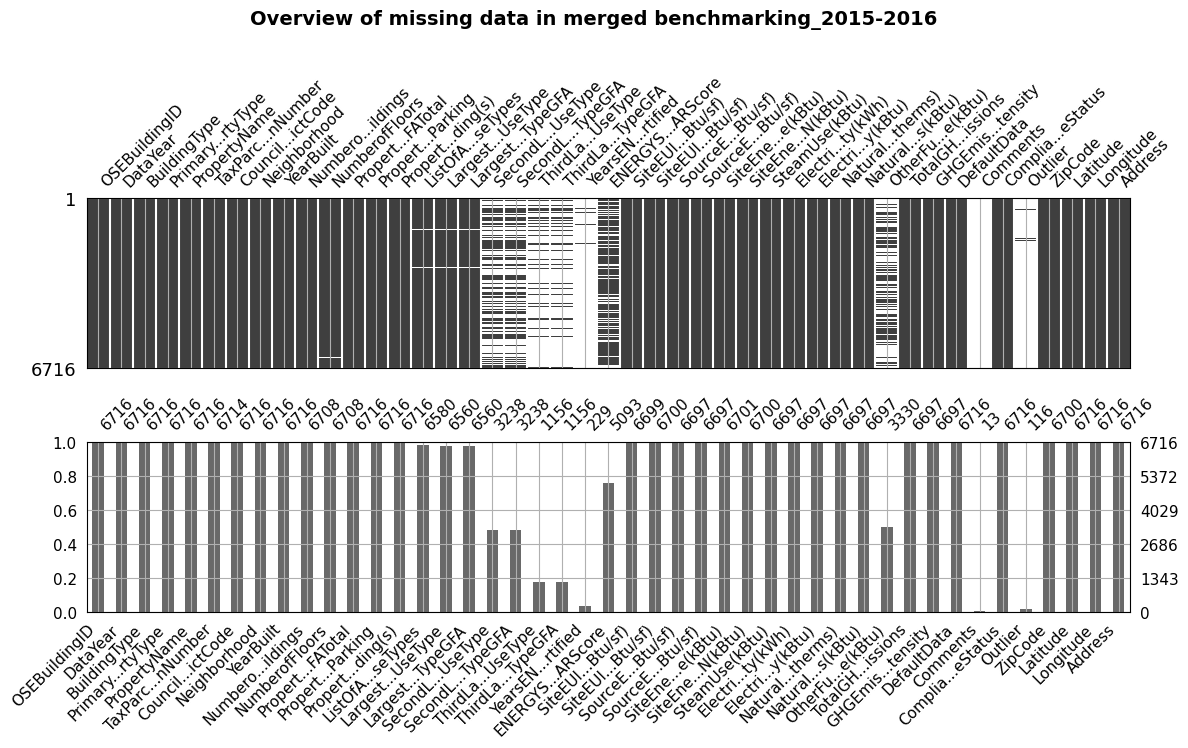

In [98]:
plot_export_missing(df, df.columns, 'missing_vals_2015_2016.png',
      'Overview of missing data in merged benchmarking_2015-2016',
                    shorten_label=True, save_enabled=False)

### 1.2 Dealing with formats

Changing list columns from strings to tuples:

- 'YearsENERGYSTARCertified'

In [99]:
def split_dates(dates):
    dates_str = str(dates).replace('nan', '')
    if ',' in dates_str:
        ls_date = [s.strip() for s in str(dates_str).split(',')]
    else:
        if len(dates_str)%4==0:
            ls_date = [dates_str[4*(i):4*(i+1)] for i in range(int(len(dates_str)/4))]
        else:
            print("ERROR: ", dates_str)
    return tuple(ls_date)


df['YearsENERGYSTARCertified'] = df['YearsENERGYSTARCertified']\
                                             .apply(lambda x: split_dates(x))

- 'ListOfAllPropertyUseTypes'

In [100]:
df['ListOfAllPropertyUseTypes'] = df['ListOfAllPropertyUseTypes']\
                                    .apply(lambda x: tuple(str(x).split(',')))

Harmonizing categories for 'ComplianceStatus' column

In [101]:
df['ComplianceStatus'] = df['ComplianceStatus']\
                                      .replace('Non-Compliant','Not Compliant')

In [102]:
df.shape, df.columns

((6716, 45),
 Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType', 'PropertyName',
        'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood', 'YearBuilt',
        'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
        'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
        'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
        'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
        'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified', 'ENERGYSTARScore',
        'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
        'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
        'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'OtherFuelUse(kBtu)',
        'TotalGHGEmissions', 'GHGEmissionsIntensity', 'DefaultData', 'Comments', 'ComplianceStatus',
        

Upper case for 'Neighborhood' and 'Address' columns.

In [103]:
sel_cols = ['PropertyName','Neighborhood' ,'Address']
df[sel_cols] = df[sel_cols].applymap(str.upper)

Stripping Tax number.

In [104]:
df['TaxParcelIdentificationNumber'] = \
                            df['TaxParcelIdentificationNumber'].str.lstrip("0")

Checking unique categories for all object columns

In [105]:
# for c in df.select_dtypes('object').columns:
#     print( "column {}: mixed ({}) 2015 ({}) 2016 ({}) categories"\
#           .format(c, df[c].nunique(),
#                   df_2015[c].nunique(), df_2016[c].nunique()))

Reindexing the merged dataframe.

In [106]:
df = df.reset_index(drop=True)

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6716 entries, 0 to 6715
Data columns (total 45 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    6716 non-null   int64  
 1   DataYear                         6716 non-null   object 
 2   BuildingType                     6716 non-null   object 
 3   PrimaryPropertyType              6716 non-null   object 
 4   PropertyName                     6716 non-null   object 
 5   TaxParcelIdentificationNumber    6714 non-null   object 
 6   CouncilDistrictCode              6716 non-null   int64  
 7   Neighborhood                     6716 non-null   object 
 8   YearBuilt                        6716 non-null   int64  
 9   NumberofBuildings                6708 non-null   float64
 10  NumberofFloors                   6708 non-null   float64
 11  PropertyGFATotal                 6716 non-null   int64  
 12  PropertyGFAParking  

### 1.2 Filtering data

#### Excluding residential housing

We only want to keep non-residential data.

In [108]:
df['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

We exclude Multifamily MR (5-9)', Multifamily LR (1-4)', 'Multifamily HR (10+)'

In [109]:
print("shape before: ", df.shape)
df = df[df['BuildingType'].isin(['NonResidential', 'Nonresidential COS', 
       'SPS-District K-12', 'Campus', 'Nonresidential WA'])]
print("shape after: ", df.shape)

shape before:  (6716, 45)
shape after:  (3318, 45)


#### Excluding duplicated buildings (2015 or 2016 only)

We exclude duplicated buildings as we want to be sure that the training set and the test set contain different buildings.

We choose to keep among the duplicates the one with fewest NaN among a selection of crucial columns. For duplicates with the same number of NaN, we keep data with larger value of 'SiteEnergyUse(kBtu)'.

In [110]:
sel_cols = ['BuildingType', 'PrimaryPropertyType', 'NumberofBuildings',
            'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
            'PropertyGFABuilding(s)', 'LargestPropertyUseType',
            'LargestPropertyUseTypeGFA', 'OSEBuildingID',
            'SiteEnergyUse(kBtu)'] # seleciton of crucial data

df_dup = df.loc[df.duplicated(subset=['OSEBuildingID'], keep=False),
                sel_cols].sort_values('OSEBuildingID').reset_index()

gb = df_dup.groupby('OSEBuildingID')[['SiteEnergyUse(kBtu)', 'index']]
mask = gb.agg({'SiteEnergyUse(kBtu)': lambda x: bool(np.argmax(x)),
               'index': lambda x: tuple(x.values)})

ind_to_drop = []
for oseid in mask.index: # keep the one with less nan
    first = mask.loc[oseid, 'index'][0]
    second = mask.loc[oseid, 'index'][1]
    if df.loc[first, sel_cols].notna().sum()<df.loc[second,
                                                    sel_cols].notna().sum():
        ind_to_drop.append(first) # keep second
    elif df.loc[first, sel_cols].notna().sum()>df.loc[second,
                                                      sel_cols].notna().sum():
        ind_to_drop.append(second) # keep first
    else: # case where nb of nan is the same
        if mask.loc[oseid,'SiteEnergyUse(kBtu)']: # True: keep the second
            ind_to_drop.append(first)
        else: # False: keep the first
            ind_to_drop.append(second)

df = df.drop(index=ind_to_drop)
print("shape after: ", df.shape)

shape after:  (1698, 45)


#### Checking coherency of 'Energy sub-columns' vs. 'SiteEnergyUse'

At first we drop the rows where 'SiteEnergyUse(kBtu)' is 0.

In [111]:
df = df.dropna(subset=['SiteEnergyUse(kBtu)'])
df = df.drop(index=df[df['SiteEnergyUse(kBtu)']==0].index)
print("shape after: ", df.shape)

shape after:  (1696, 45)


We check that the column 'SiteEnergyUse(kBtu)' is the sum of the energy columns in (kBtu).

In [112]:
sub_energy_cols = ['SteamUse(kBtu)','Electricity(kBtu)',
                   'NaturalGas(kBtu)','OtherFuelUse(kBtu)']
df['SiteEnergyUse(kBtu)_calc'] = df[sub_energy_cols].sum(axis='columns')
m_en_out = ~df['SiteEnergyUse(kBtu)_calc'].between(df['SiteEnergyUse(kBtu)']*0.9,
                                                  df['SiteEnergyUse(kBtu)']*1.1)
print("Rows where the total energy is not\n \
in [90%-110%] range of the 'SiteEnergyUse(kBtu)': ",
df[m_en_out].shape[0], '/', df.shape[0])

Rows where the total energy is not
 in [90%-110%] range of the 'SiteEnergyUse(kBtu)':  10 / 1696


We drop the rows when 'SiteEnergyUse(kBtu)' is not in 90% to 110% of the calculated value.
When it is inside the is not in [90%-110%] interval, we nevertheless adjust the value of 'SiteEnergyUse(kBtu)' to the calculated value.

In [113]:
df = df.drop(index=df[m_en_out].index)
df['SiteEnergyUse(kBtu)'] = df['SiteEnergyUse(kBtu)_calc']
del df['SiteEnergyUse(kBtu)_calc']
print("shape after: ", df.shape)

shape after:  (1686, 45)


#### Checking coherency of 'GFA sub-columns' vs. 'PropertyGFATotal'

Checking that the column 'PropertyGFATotal' is the sum of the sub GFA columns.

Ther is two subsets of columns that are supposed to represent the totality of the area:
- parking area or building area
- three largest property use GFA

In [114]:
sub_GFA_cols1 = ['PropertyGFAParking', 'PropertyGFABuilding(s)']
sub_GFA_cols2 = ['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA']

In [115]:
df['PropertyGFATotal_calc'] = df[sub_GFA_cols1].sum(axis='columns')
m_GFA_out = ~df['PropertyGFATotal_calc'].between(df['PropertyGFATotal']*0.99,
                                                  df['PropertyGFATotal']*1.01)
print("Rows where the total GFA is not\n \
in [99%-101%] range of the 'PropertyGFATotal': ",
df[m_GFA_out].shape[0], '/', df.shape[0])

# df = df.drop(index=df[m_GFA_out].index)
# df['PropertyGFATotal'] = df['PropertyGFATotal_calc']
# del df['PropertyGFATotal_calc']

Rows where the total GFA is not
 in [99%-101%] range of the 'PropertyGFATotal':  0 / 1686


The total GFA is very precisely the sum of the parking area and the building area.

In [116]:
df['PropertyGFATotal_calc'] = df[sub_GFA_cols2].sum(axis='columns')
m_GFA_out = df['PropertyGFATotal_calc'].dropna().between(df['PropertyGFATotal']*1.000000000001,
                                                  df['PropertyGFATotal']*6)
print("Rows where the total GFA is not\n \
in [100%-700%] range of the 'PropertyGFATotal': ",
df[m_GFA_out].shape[0], '/', df.shape[0])

# df = df.drop(index=df[m_GFA_out].index)
# df['PropertyGFATotal'] = df['PropertyGFATotal_calc']
# del df['PropertyGFATotal_calc']

# 412 : entre 1 et 7

Rows where the total GFA is not
 in [100%-700%] range of the 'PropertyGFATotal':  411 / 1686


Whereas the sum of the GFA use types are sometimes less than 1 or can reach 7...

In [117]:
speak('filtering of data: done')

### 1.3 Imputation of missing data

Columns can be split in three categories:
- **unused data**: too precise id data
- **properties**: not directly linked to CO2 emission metrics, thus can be used for the model without fearing data leakage. Some are quantitative, others are categorical and will have to be encoded.
- **energy performance metrics**: data related with the metrics we want to calculate with our model, thus should not be used as input data for the model. However we can extract useful data from these.

In [118]:
id_cols = ['OSEBuildingID', 'TaxParcelIdentificationNumber',
               'CouncilDistrictCode', 'Neighborhood',
               'ListOfAllPropertyUseTypes'] # redondante ?

prop_cols = ['BuildingType', 'PrimaryPropertyType',
            'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
            'PropertyGFAParking','PropertyGFABuilding(s)',
            'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
            'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
            'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA']

prop_C_cols = list(df[prop_cols].select_dtypes('object').columns) # to encode
prop_Q_cols = list(df[prop_cols].select_dtypes(np.number).columns)

en_perf_metrics_cols = ['ENERGYSTARScore',
                        'SiteEUI(kBtu/sf)',
                        'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)',
                        'SourceEUIWN(kBtu/sf)','SiteEnergyUse(kBtu)'
                        'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
                        'Electricity(kWh)','Electricity(kBtu)',
                        'NaturalGas(therms)', 'NaturalGas(kBtu)',
                        'OtherFuelUse(kBtu)', 'TotalGHGEmissions',
                        'GHGEmissionsIntensity']

In [119]:
# plot_export_missing(df, prop_Q_cols, 'missing_vals_quant_2015_2016.png',
#                     'Overview of missing \nquantitative data',
#                     figsize=(4,8),shorten_label=True, save_enabled=False)

In [120]:
# plot_export_missing(df, prop_C_cols, 'missing_vals_categ_2015_2016.png',
#                     'Overview of missing \ncategorical data',
#                     figsize=(3,8),shorten_label=True, save_enabled=False)

In [121]:
for c in prop_cols+['SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(therms)',
   'NaturalGas(kBtu)','OtherFuelUse(kBtu)']+['YearBuilt']:
    n = df[c].isna().sum()
    if n>0:
        print('o--',c, ': ',str(n)," MISSING VALUES !")
    else:
        print(c, "no missing values.")

BuildingType no missing values.
PrimaryPropertyType no missing values.
NumberofBuildings no missing values.
NumberofFloors no missing values.
PropertyGFATotal no missing values.
PropertyGFAParking no missing values.
PropertyGFABuilding(s) no missing values.
o-- LargestPropertyUseType :  12  MISSING VALUES !
o-- LargestPropertyUseTypeGFA :  12  MISSING VALUES !
o-- SecondLargestPropertyUseType :  828  MISSING VALUES !
o-- SecondLargestPropertyUseTypeGFA :  828  MISSING VALUES !
o-- ThirdLargestPropertyUseType :  1335  MISSING VALUES !
o-- ThirdLargestPropertyUseTypeGFA :  1335  MISSING VALUES !
SteamUse(kBtu) no missing values.
Electricity(kBtu) no missing values.
NaturalGas(therms) no missing values.
NaturalGas(kBtu) no missing values.
o-- OtherFuelUse(kBtu) :  943  MISSING VALUES !
YearBuilt no missing values.


Very few missing data except for:
- quantitative: _'SecondLargestPropertyUseTypeGFA',  'ThirdLargestPropertyUseTypeGFA' and 'OtherFuelUse(kBtu)'_
- categorical: 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType'

We'll impute :
- quantitative data of energy in kBtu _('OtherFuelUse(kBtu)')_ to 0 if NaN
- other data with less than 10% missing values _( 'LargestPropertyUseTypeGFA') and ('LargestPropertyUseType')_ will be imputed using knn imputer, (we'll use completely filled data to train the knn).

- the data with more than 50% missing data
_('SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', ''OtherFuelUse(kBtu)')_ and _('SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType')_ will be set to 0 or to 'None' as it probably simply means that there is no Second or Third largest Proporty Use at all.

#### Case 'optional' missing data: setting to 0 or 'None'

In [122]:
for c in ['SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
          'OtherFuelUse(kBtu)']:
    df[c] = df[c].fillna(0)
for c in ['SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']:
    df[c] = df[c].fillna('None')

#### Case missing data < 10%: KNN imputation

In [123]:
# var_model: to train | var_target: to impute

filled_cols = ['BuildingType', 'PrimaryPropertyType', 'NumberofBuildings',
               'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
               'PropertyGFABuilding(s)']

# Automatic KNN classification
ind_to_impute, y_pr_ = knn_impute(df, var_model = filled_cols,
                                  var_target='LargestPropertyUseType',
                                    enc_strat_cat='label', plot=False)
print('Number of values to impute:', len(ind_to_impute))
df.loc[ind_to_impute, 'LargestPropertyUseType'] = y_pr_

# Automatic KNN regression
ind_to_impute, y_pr_ = knn_impute(df, var_model = filled_cols,#+['LargestPropertyUseType'],
                                  var_target='LargestPropertyUseTypeGFA',
                                    enc_strat_cat='label', plot=False)
print('Number of values to impute:', len(ind_to_impute))
df.loc[ind_to_impute, 'LargestPropertyUseTypeGFA'] = y_pr_

ooo----KNN CLASSIFICATION : LargestPropertyUseType
--- model: f1=0.809, precision=0.809, recall=0.809
--- dummy class. (stratified): f1=0.137, precision=0.137, recall=0.137
--- dummy class. (most_frequent): f1=0.301, precision=0.301, recall=0.301
--- dummy class. (uniform): f1=0.0179, precision=0.0179, recall=0.0179
Number of values to impute: 12
ooo----KNN REGRESSION : LargestPropertyUseTypeGFA
--- model: 0.872
--- normal random distribution: -0.478
--- dummy regressor (mean) : r2_score=-8.87e-05
--- dummy regressor (median) : r2_score=-0.137
Number of values to impute: 12


In [124]:
speak('imputation of missing data: done')

### 1.4 Feature Engineering

#### Age of the building

Deducing the building age or thedelay since the last major renovation (see metadata in json file) from building year and data year.

In [125]:
df['BuildingAge'] = df['DataYear'].astype(int)-df['YearBuilt']

#### Mean GFA per floor

Deducing the mean GFA per floor from 'PropertyGFATotal' and 'NumberofFloors'.

In [126]:
df = df.drop(df[df['PropertyGFABuilding(s)']<0].index)

In [127]:
df['MeanGFAperFloor'] = df['PropertyGFABuilding(s)']/(df['NumberofFloors']+1)

#### Parking GFA ratio

Deducing the surface of parkings ratio to the whole area.

In [128]:
df['ParkingGFARatio'] = df['PropertyGFAParking']/df['PropertyGFATotal']

#### Having the EnergySTAR certification or not

From the column 'YearsENERGYSTARCertified', we can deduce:
- if the building was certified during DataYear
- if the building was certified the year prior to DataYear.

Both could be used without data leakage as EnergySTAR only reflects energy efficiency of the buildings and not the actual energy consumption, however we take only 'CertifiedPreviousYear' as we may not know in advance if a building will be certified this year.

In [196]:
df[df['YearsENERGYSTARCertified']!=()]['YearsENERGYSTARCertified']

74                                                                                         (2016,)
88                                                                                         (2016,)
107                                                                                        (2014,)
232                                                                                        (2016,)
272                                                                                        (2016,)
408                                                                                        (2012,)
413                                                                                   (2017, 2015)
415                                         (2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008)
419                                                                             (2010, 2009, 2007)
423                                                                             (2017, 2010, 2007)
425       

In [129]:
df['Certified'] = [False if t == () else d in t for d, t \
                   in df[['DataYear', 'YearsENERGYSTARCertified']].values]
df['CertifiedPreviousYear'] = [False if t == () else \
                               int(d)-1 in [int(d) for d in t] \
                               for d, t in df[['DataYear',
                                               'YearsENERGYSTARCertified']].values]

#### Determining an energy consumption profile

If we want to avoid data leakage, we'll avoid to take as any of the energy consumption (kBtu) data as parameters for our model, as energy consumption won't be available when we'll have to predict GHG Emissions.
However, we could imagine building a consumption profile of the buildings based on the available equipment.
For exemple, buildings with electrical heating apparatus are likely to use electricity as their main energy source throughout the year.

We'll build a 'Profile' column based on precise consumption data columns, but we'll try to keep the categories wide enough to avoid data leakage.

At first we calculate the proportion of SteamUse, Electricity, NaturalGas(therms), NaturalGas and OtherFuelUse and store the results in new columns.

In [130]:
sub_energy_ratio_cols = ['SteamUse(ratio)','Electricity(ratio)',
            'NaturalGas(ratio)','OtherFuelUse(ratio)']

for oc, nc in zip(sub_energy_cols, sub_energy_ratio_cols):
    df[nc] = df[oc]/df['SiteEnergyUse(kBtu)']


We plot the dispersion of these calculated ratio to have an idea of relevant boundaries for bining.

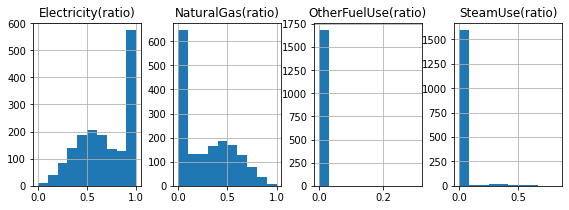

In [131]:
df[sub_energy_ratio_cols].hist(layout=(1,5))
plt.gcf().set_size_inches(12,3)

We will create new columns to have an overview of the energetic profile of the building.

* _First option_: divide in 3 bins the consumption rate of each type of energy (steam 's', electricity 'e', gas 'g' and other 'o'), and aggregate the bins to make a profile.

    for example:
    - (0.67-1] steam, (0-0.33] gas, (0-0.33] electricity and (0-0.33] other -> S(geo)
    - (0.33-0.67] steam, (0.33-0.67] electricity, (0-0.33] gas and (0-0.33] other -> se(go)
    - (0.33-0.67] other, (0-0.33] electricity, (0-0.33] gas and (0-0.33] other -> o(seg)

* _Second option_: a new column specifying the main energy source used.

    for example: S, E, G, O for steam, electricity, natural gas or other.


__First option__

In [132]:
sub_energy_bins_cols = ['SteamUse(bins)','Electricity(bins)',
            'NaturalGas(bins)','OtherFuelUse(bins)']

for oc, nc in zip(sub_energy_ratio_cols, sub_energy_bins_cols):
    df[nc] = pd.cut(df[oc], bins=[0,0.33,0.67,1],
                    labels=[f'({oc[0].lower()})', oc[0].lower(), oc[0]],
                    include_lowest=True)
    
df['EnergyProfile'] = df[sub_energy_bins_cols].apply(lambda x: ''.join(x),
                                                     axis=1)

Visualizing the count of rows for each profile.

In [133]:
df['EnergyProfile'].value_counts()

(s)E(n)(o)    892
(s)en(o)      564
(s)(e)N(o)    159
se(n)(o)       47
(s)e(n)(o)     15
s(e)(n)(o)      3
S(e)(n)(o)      3
(s)(e)n(o)      2
Name: EnergyProfile, dtype: int64

* __Second option__

In [134]:
df['MainEnergy'] = df[sub_energy_ratio_cols].apply(np.argmax, axis=1)
df['MainEnergy'] = df['MainEnergy'].map({0: 'Steam',
                                         1: 'Electricity',
                                         2: 'NaturalGas',
                                         3: 'OtherFuel'})

Adding the feature engineered columns to the list of available features to use in our model.

In [135]:
prop_cols += ['BuildingAge', 'MeanGFAperFloor', 'ParkingGFARatio',
              'CertifiedPreviousYear', 'EnergyProfile', 'MainEnergy']                                 
prop_Q_cols += ['BuildingAge', 'MeanGFAperFloor', 'ParkingGFARatio']
prop_C_cols += ['CertifiedPreviousYear', 'EnergyProfile', 'MainEnergy'] 

In [136]:
speak('feature engineering: done')

## 2 Data exploration

#### Describe

In [137]:
df[prop_cols].describe(include='all')

,BuildingType,PrimaryPropertyType,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,BuildingAge,MeanGFAperFloor,ParkingGFARatio,CertifiedPreviousYear,EnergyProfile,MainEnergy
count,1685,1685,1685.00,1685.00,1685.00,1685.00,1685.00,1685,1685.00,1685,1685.00,1685,1685.00,1685.00,1685.00,1685.00,1685,1685,1685
unique,5,29,nan,nan,nan,nan,nan,57,nan,47,nan,40,nan,nan,nan,nan,2,8,3
top,NonResidential,Small- and Mid-Sized Office,nan,nan,nan,nan,nan,Office,nan,None,nan,None,nan,nan,nan,nan,False,(s)E(n)(o),Electricity
freq,1479,297,nan,nan,nan,nan,nan,506,nan,827,nan,1334,nan,nan,nan,nan,1649,892,1241
mean,NaN,NaN,1.12,4.11,113013.96,13598.72,99415.24,NaN,93499.83,NaN,19000.85,NaN,3079.62,53.82,22696.92,0.06,NaN,NaN,NaN
std,NaN,NaN,1.44,6.54,193247.68,45012.28,169126.87,NaN,159706.07,NaN,53319.37,NaN,17839.75,32.84,44113.64,0.14,NaN,NaN,NaN
min,NaN,NaN,0.00,0.00,11285.00,0.00,3636.00,NaN,6455.00,NaN,0.00,NaN,0.00,1.00,219.48,0.00,NaN,NaN,NaN
25%,NaN,NaN,1.00,1.00,29380.00,0.00,28309.00,NaN,25450.00,NaN,0.00,NaN,0.00,26.00,9053.00,0.00,NaN,NaN,NaN
50%,NaN,NaN,1.00,2.00,49052.00,0.00,47265.00,NaN,43473.00,NaN,0.00,NaN,0.00,50.00,13800.00,0.00,NaN,NaN,NaN
75%,NaN,NaN,1.00,4.00,105100.00,0.00,94500.00,NaN,91935.00,NaN,12824.00,NaN,0.00,86.00,22161.33,0.00,NaN,NaN,NaN


### 2.1 Quantitative data

#### Boxplots

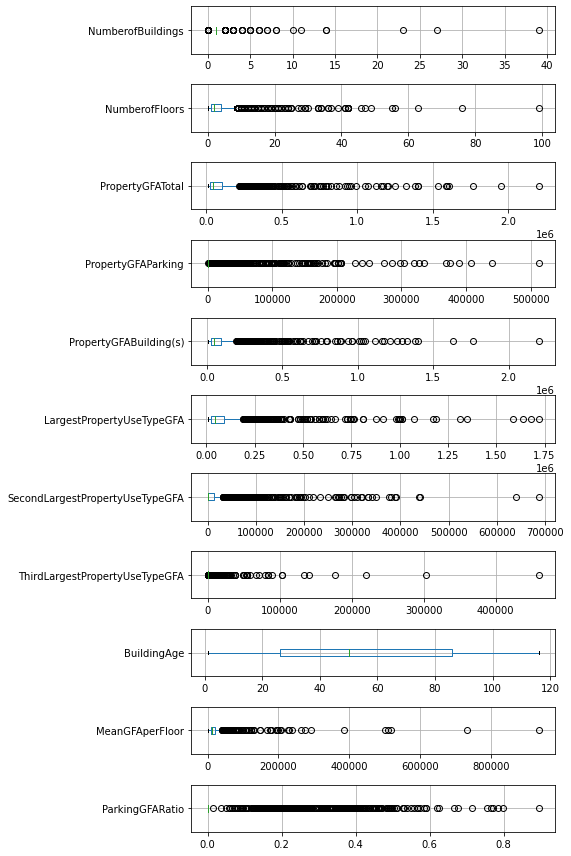

In [138]:
fig, axs = plt.subplots(len(df[prop_Q_cols].columns),1,
                        figsize=(8, 12), sharey=False)
for c, ax in zip(df[prop_Q_cols].columns, axs):
    df.boxplot(c, vert=False, ax=ax)
fig.tight_layout(h_pad=0.051)
if save_enabled: plt.savefig(os.getcwd()+'/FIG/'+'2_1_boxplots.png',
                             dpi=400);
plt.show()

#### Histograms

Plotting histograms of the main quantitative continuous columns.

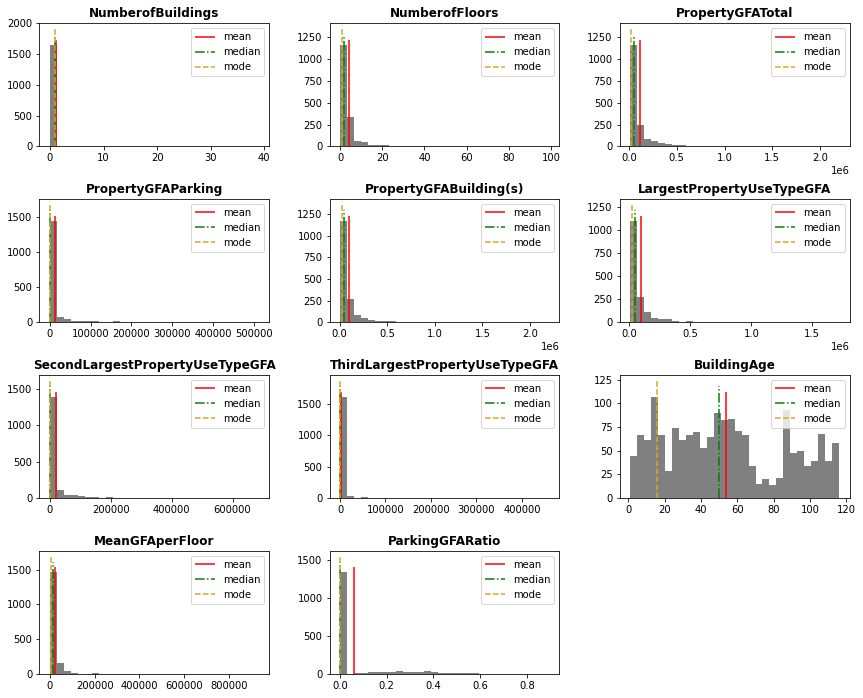

In [139]:
plot_histograms(df=df, cols=prop_Q_cols, file_name='2_1_histograms.png',
                figsize=(12,12), layout=(5,3), save_enabled=save_enabled)

QQ plots and normality tests

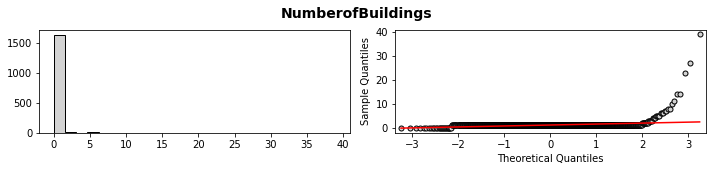

,stat,p_value,res
Shapiro-Wilk,0.080,0.000,False
D'Agostino K^2,"3,563.443",0.000,False
Anderson-Darling,591.789,nan,"[(15, False), (10, False), (5, False), (2, False), (1, False)]"


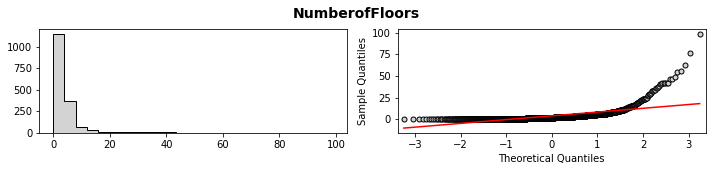

,stat,p_value,res
Shapiro-Wilk,0.444,0.000,False
D'Agostino K^2,"1,980.867",0.000,False
Anderson-Darling,264.219,nan,"[(15, False), (10, False), (5, False), (2, False), (1, False)]"


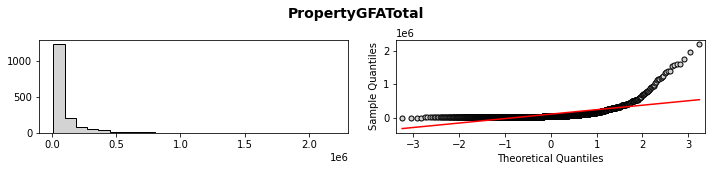

,stat,p_value,res
Shapiro-Wilk,0.471,0.000,False
D'Agostino K^2,"1,706.523",0.000,False
Anderson-Darling,269.969,nan,"[(15, False), (10, False), (5, False), (2, False), (1, False)]"


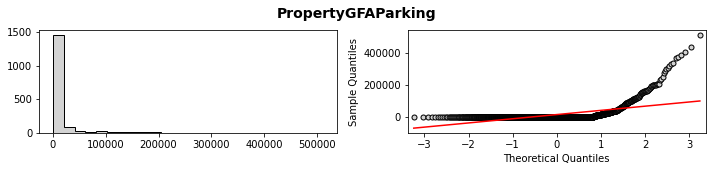

,stat,p_value,res
Shapiro-Wilk,0.341,0.000,False
D'Agostino K^2,"1,773.957",0.000,False
Anderson-Darling,430.772,nan,"[(15, False), (10, False), (5, False), (2, False), (1, False)]"


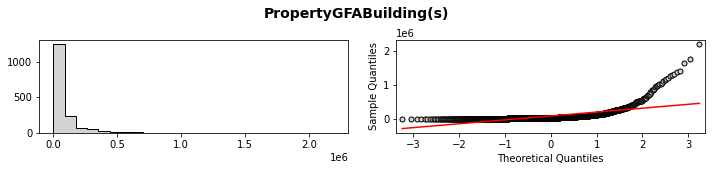

,stat,p_value,res
Shapiro-Wilk,0.451,0.000,False
D'Agostino K^2,"1,816.961",0.000,False
Anderson-Darling,277.100,nan,"[(15, False), (10, False), (5, False), (2, False), (1, False)]"


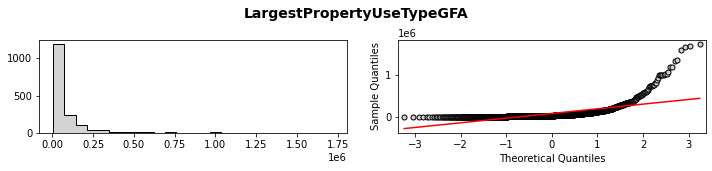

,stat,p_value,res
Shapiro-Wilk,0.468,0.000,False
D'Agostino K^2,"1,750.839",0.000,False
Anderson-Darling,266.868,nan,"[(15, False), (10, False), (5, False), (2, False), (1, False)]"


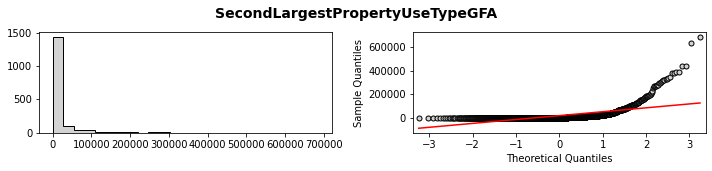

,stat,p_value,res
Shapiro-Wilk,0.386,0.000,False
D'Agostino K^2,"1,872.102",0.000,False
Anderson-Darling,350.876,nan,"[(15, False), (10, False), (5, False), (2, False), (1, False)]"


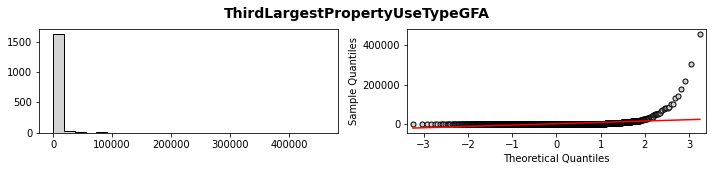

,stat,p_value,res
Shapiro-Wilk,0.149,0.000,False
D'Agostino K^2,"3,368.496",0.000,False
Anderson-Darling,488.274,nan,"[(15, False), (10, False), (5, False), (2, False), (1, False)]"


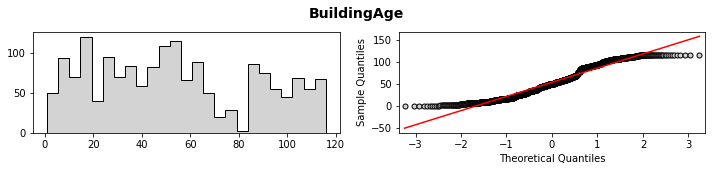

,stat,p_value,res
Shapiro-Wilk,0.949,0.000,False
D'Agostino K^2,530.580,0.000,False
Anderson-Darling,23.342,nan,"[(15, False), (10, False), (5, False), (2, False), (1, False)]"


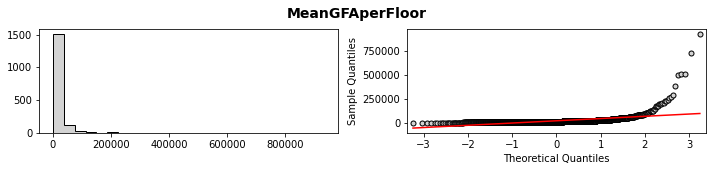

,stat,p_value,res
Shapiro-Wilk,0.287,0.000,False
D'Agostino K^2,"2,878.990",0.000,False
Anderson-Darling,324.341,nan,"[(15, False), (10, False), (5, False), (2, False), (1, False)]"


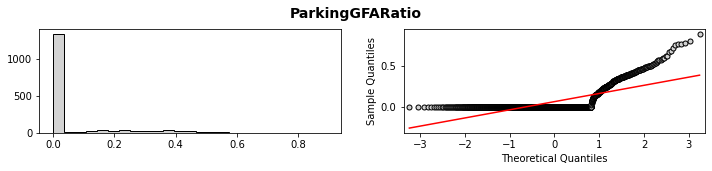

,stat,p_value,res
Shapiro-Wilk,0.516,0.000,False
D'Agostino K^2,814.305,0.000,False
Anderson-Darling,381.241,nan,"[(15, False), (10, False), (5, False), (2, False), (1, False)]"


In [140]:
for i, c in enumerate(df[prop_Q_cols].columns,1):
    plot_hist_qqplot(df[c].dropna().values, c, save=False)
    plt.show()
    with pd.option_context('display.float_format', '{:,.3f}'.format):
        display(normality_tests(df[c], print_opt=False))

None of the quantitative data have normal distribution.

#### Correlations

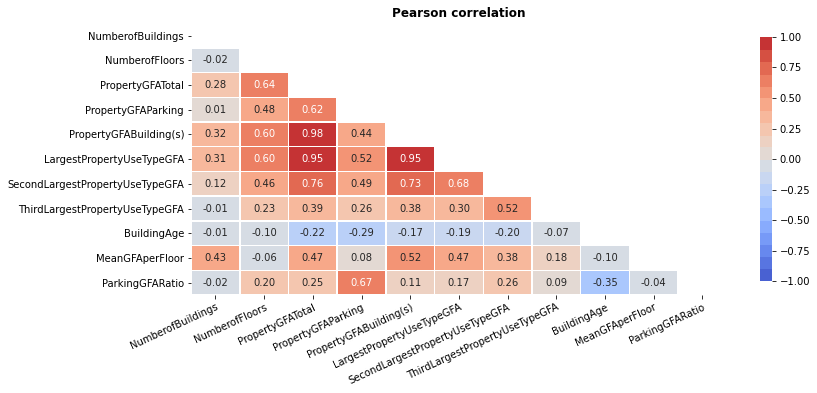

In [141]:
# Linear correlation (Pearson)

pears_corr = df[prop_Q_cols].corr()
plot_heatmap(pears_corr, shape='tri',
             title="Pearson correlation", figsize=(12,5))
if save_enabled: plt.savefig(os.getcwd()+'/FIG/'+'2_1_pearson.png',
                             dpi=400);
plt.show()

In [142]:
# Correlation test

test_couples = [('PropertyGFATotal','PropertyGFABuilding(s)'),
                ('PropertyGFATotal','LargestPropertyUseTypeGFA'),
                ('PropertyGFATotal','NumberofFloors'),
                ('PropertyGFATotal','PropertyGFAParking'),
                ('ParkingGFARatio','PropertyGFAParking'),
                ('NumberofFloors','LargestPropertyUseTypeGFA'),
                ('MeanGFAperFloor','PropertyGFABuilding(s)'),
                ('SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA'),
                ('NumberofFloors','PropertyGFABuilding(s)'),
                ('ParkingGFARatio','BuildingAge'),
                ('NumberofFloors','BuildingAge')]

for tup in test_couples:
    print('------'+str(tup).upper()+'-----')
    c1, c2 = tup
    display(correlation_tests(df[c1], df[c2], print_opt=False))
del tup

------('PROPERTYGFATOTAL', 'PROPERTYGFABUILDING(S)')-----


,stat,p_value
Pearson,0.98,0.00
Spearman,0.98,0.00
Kendall,0.93,0.00


------('PROPERTYGFATOTAL', 'LARGESTPROPERTYUSETYPEGFA')-----


,stat,p_value
Pearson,0.95,0.00
Spearman,0.92,0.00
Kendall,0.79,0.00


------('PROPERTYGFATOTAL', 'NUMBEROFFLOORS')-----


,stat,p_value
Pearson,0.64,0.00
Spearman,0.50,0.00
Kendall,0.38,0.00


------('PROPERTYGFATOTAL', 'PROPERTYGFAPARKING')-----


,stat,p_value
Pearson,0.62,0.00
Spearman,0.44,0.00
Kendall,0.36,0.00


------('PARKINGGFARATIO', 'PROPERTYGFAPARKING')-----


,stat,p_value
Pearson,0.67,0.00
Spearman,0.99,0.00
Kendall,0.93,0.00


------('NUMBEROFFLOORS', 'LARGESTPROPERTYUSETYPEGFA')-----


,stat,p_value
Pearson,0.60,0.00
Spearman,0.44,0.00
Kendall,0.33,0.00


------('MEANGFAPERFLOOR', 'PROPERTYGFABUILDING(S)')-----


,stat,p_value
Pearson,0.52,0.00
Spearman,0.72,0.00
Kendall,0.54,0.00


------('SECONDLARGESTPROPERTYUSETYPEGFA', 'THIRDLARGESTPROPERTYUSETYPEGFA')-----


,stat,p_value
Pearson,0.52,0.00
Spearman,0.55,0.00
Kendall,0.49,0.00


------('NUMBEROFFLOORS', 'PROPERTYGFABUILDING(S)')-----


,stat,p_value
Pearson,0.60,0.00
Spearman,0.47,0.00
Kendall,0.35,0.00


------('PARKINGGFARATIO', 'BUILDINGAGE')-----


,stat,p_value
Pearson,-0.35,0.00
Spearman,-0.37,0.00
Kendall,-0.29,0.00


------('NUMBEROFFLOORS', 'BUILDINGAGE')-----


,stat,p_value
Pearson,-0.10,0.00
Spearman,-0.08,0.00
Kendall,-0.05,0.01


#### PCA

In [143]:
df[prop_Q_cols].shape, df[prop_C_cols].shape

((1685, 11), (1685, 8))

In [144]:
np.set_printoptions(formatter={'float': '{: 6.2f}'.format})
df_pca = df.loc[:, prop_Q_cols].dropna(how='any')
id_code = df_pca.index
X = df_pca.values

X_sc = StandardScaler().fit_transform(X)

n_comp = 11
pca = PCA(n_components=n_comp).fit(X_sc)

pca_df = pd.DataFrame(pca.components_,
                      index=['PC'+str(i+1) for i in range(n_comp)],
                      columns=prop_Q_cols).T

X_proj = pca.transform(X_sc)

Plotting principal components

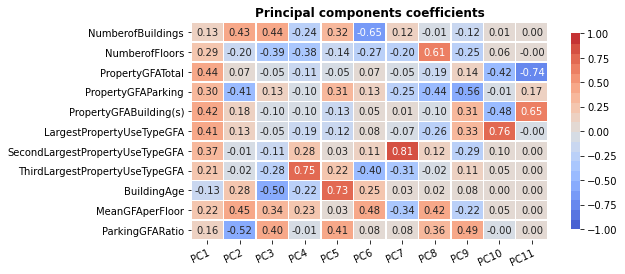

In [145]:
plot_heatmap(pca_df,'Principal components coefficients', vmin=-1, vmax=1, center=0,
             palette=sns.color_palette("coolwarm", 20),figsize=(8,4),shape='rect')
if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'2_1_pca_princ_comp.png',
                             dpi=400);
plt.show()

Plotting explained variance ratio in scree plot

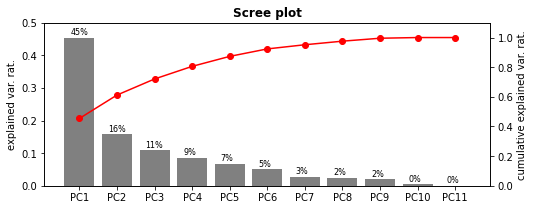

In [146]:
exp_var_rat = pca.explained_variance_ratio_
scree_plot(col_names= pca_df.columns, exp_var_rat=exp_var_rat, ylim=(0,0.5))
if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'2_1_scree_plot.png',
                             dpi=400);
plt.show()

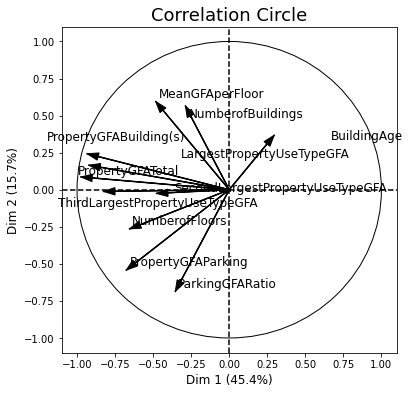

In [147]:
figure, correlation_matrix = \
     plot_pca_correlation_graph(X = X_sc, variables_names = prop_Q_cols,
                                dimensions=(1, 2), figure_axis_size=6)
                                # X_pca = X_proj[:,0:2],
                                # explained_variance = exp_var_rat[0:2])
if save_enabled: plt.savefig(os.getcwd()+'/FIG/'+'2_1_pca_corr_cir_1-2.png',
                             dpi=400);
plt.show()

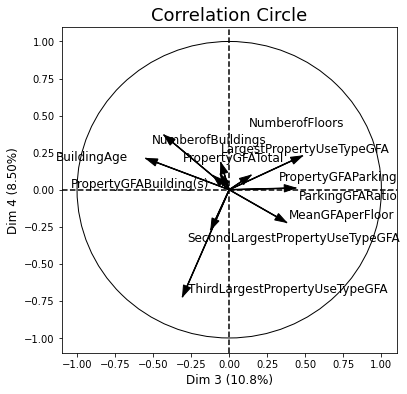

In [148]:
figure, correlation_matrix = \
     plot_pca_correlation_graph(X = X_sc, variables_names = prop_Q_cols,
                                dimensions=(3, 4), figure_axis_size=6)#,
                                # X_pca = X_proj[:,2:4],
                                # explained_variance = exp_var_rat[2:4])
if save_enabled: plt.savefig(os.getcwd()+'/FIG/'+'2_1_pca_corr_cir_3-4.png',
                             dpi=400);
plt.show()

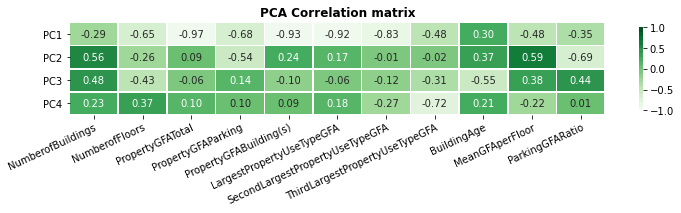

In [149]:
plot_heatmap(correlation_matrix.T,'PCA Correlation matrix',
             vmin=-1, vmax=1, center=0,
             palette=sns.color_palette("Greens", 20),
             figsize=(12,1.7),shape='rect')
plt.gca().set_yticklabels(['PC1', 'PC2', 'PC3', 'PC4'])
if save_enabled: plt.savefig(os.getcwd()+'/FIG/'+'A_4_1_correaltion_matrix.png',
                             dpi=400);
plt.show()

### 2.2 Categorical data

#### Bar plots

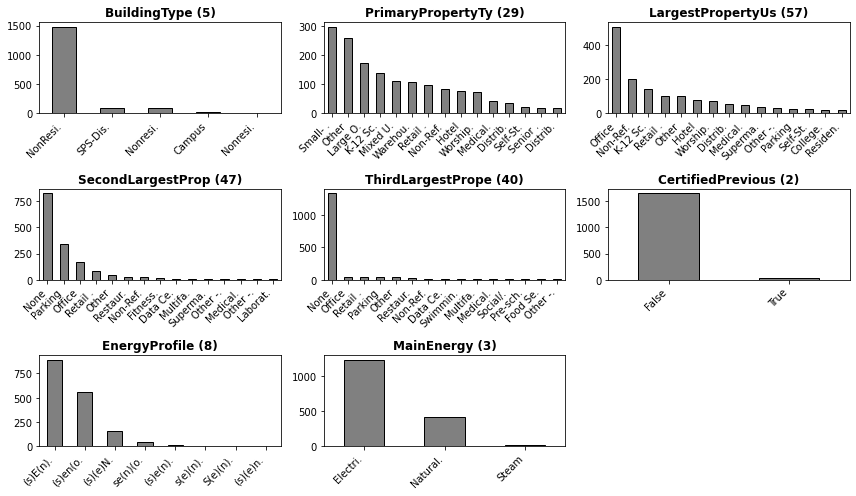

In [150]:
plot_barplots(df=df, cols=prop_C_cols, figsize=(12,7),
              file_name = '2_2_bar_plots.png',
              layout=(3,3), save_enabled=save_enabled)
plt.show()

#### Predictive Power Score

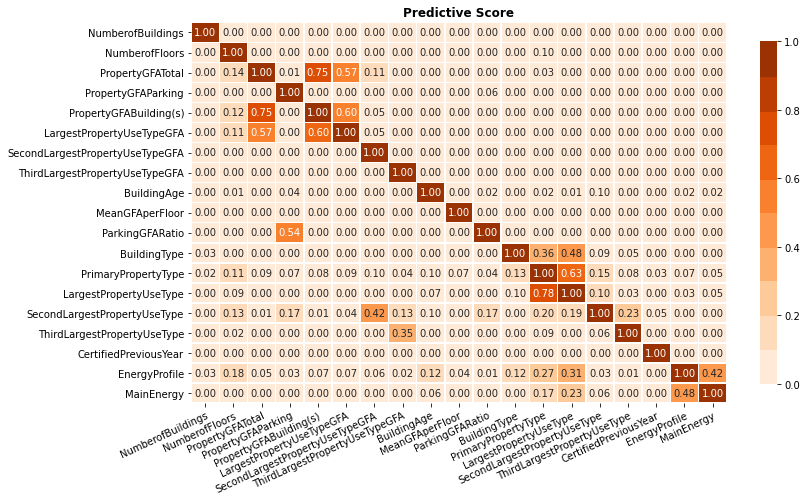

In [151]:
# Predictive Power Score on main features (ppscore)

pps_corr = pps.matrix(df[prop_Q_cols+prop_C_cols])
plot_heatmap(pps_corr, title="Predictive Score", 
             vmin=0, center=0.5, vmax=1, figsize=(12,7), shape='rect',
             palette=sns.color_palette("Oranges", 10))
if save_enabled: plt.savefig(os.getcwd()+'/FIG/'+'2_2_ppscore.png',
                             dpi=400);
plt.show()

Contingency table showing 'LargestPropertyUseType' vs. 'LargestPropertyUseType' categories

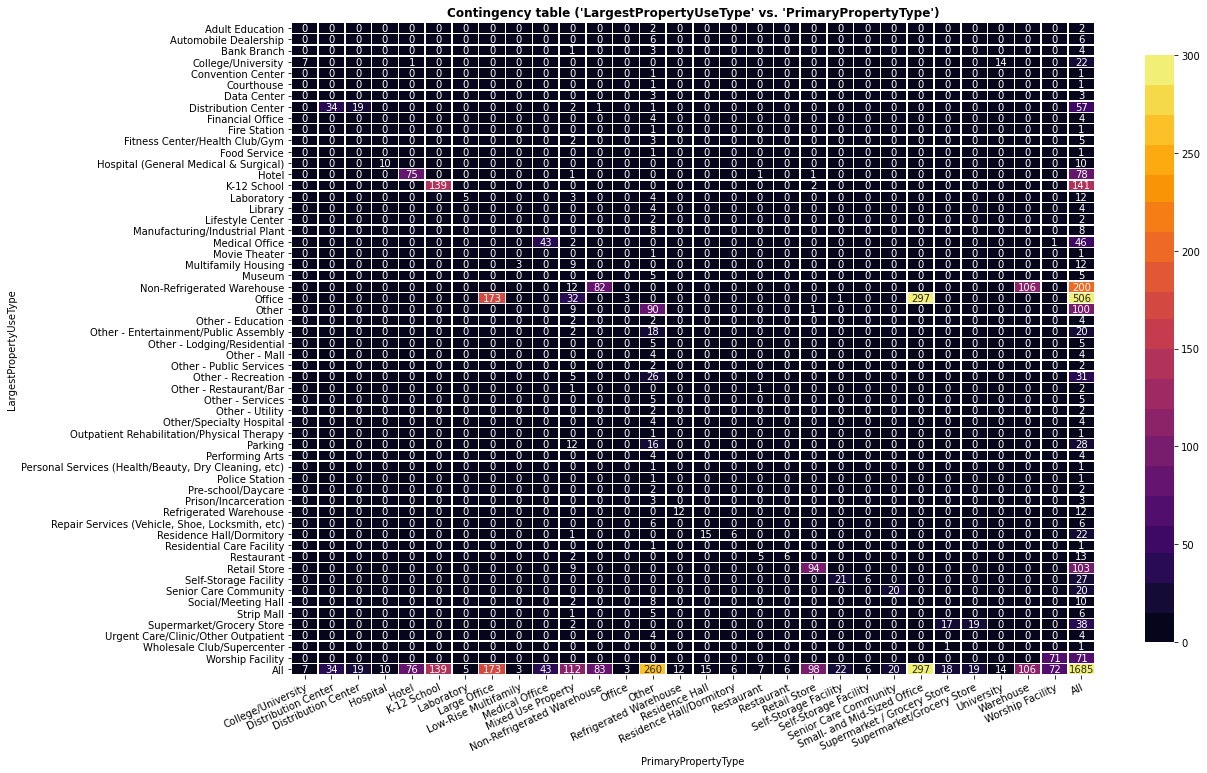

---Chi-squared
stat=26851.541, p=0.000
Probably dependent


In [152]:
data_crosstab = pd.crosstab(df['LargestPropertyUseType'], 
                            df['PrimaryPropertyType'],  
                               margins = True)

plot_heatmap(data_crosstab,
             "Contingency table ('LargestPropertyUseType' vs. 'PrimaryPropertyType')",
             vmin=0, center=150, vmax=300, palette=sns.color_palette("inferno", 20),
             figsize=(18,12), shape='rect', fmt='.0f')
if save_enabled: plt.savefig(os.getcwd()+'/FIG/'+'2_2_nutrig_clusters.png', dpi=400);
plt.show()

# Chi-Squared Test
from scipy.stats import chi2_contingency
stat, p, dof, expected = chi2_contingency(data_crosstab)
print('---'+"Chi-squared")
print('stat=%.3f, p=%.3f' % (stat, p))
print('Probably independent') if p > 0.05 else print('Probably dependent')

## 3 Modelling

In [153]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_pca_correlation_graph

import category_encoders as ce

from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.linear_model import Ridge, Lasso, Lars, LinearRegression, ElasticNet, huber, ransac, theil_sen
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR

### 3.1 Data preprocessing

#### Features selection

__Quantitative data__

Excluding highly correlated quantitative features.
- 'PropertyGFATotal' is strongly correlated with 'PropertyGFABuilding(s)'
- 'PropertyGFABuilding(s)' is strongly correlated with 'LargestPropertyUseTypeGFA'


__Categorical data__

Excluding highly related categorical features.
- 'LargestPropertyUseType'(57) is strongly correlated with 'PrimaryPropertyType'(29)

In [154]:
prop_Q_cols_sel = [c for c in prop_Q_cols if c not in\
                              ['PropertyGFATotal', 'PropertyGFABuilding(s)']]
prop_Q_cols_sel

['NumberofBuildings',
 'NumberofFloors',
 'PropertyGFAParking',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseTypeGFA',
 'BuildingAge',
 'MeanGFAperFloor',
 'ParkingGFARatio']

In [155]:
prop_C_cols_sel = [c for c in prop_C_cols if c not in ['PrimaryPropertyType']]
prop_C_cols_sel

['BuildingType',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType',
 'CertifiedPreviousYear',
 'EnergyProfile',
 'MainEnergy']

Training and testing set splitting

In [156]:
df_X = df[prop_Q_cols_sel+prop_C_cols_sel]
df_y1 = df['SiteEnergyUse(kBtu)']
# df_y2 = df['TotalGHGEmissions']

In [157]:
# Stratified split (choisir les colonnes)
X_tr, X_te, y1_tr, y1_te = train_test_split(df_X, df_y1,
                                            train_size=0.8, shuffle=True)

#### Applying estimators and encoding

__Quantitative data__

Standardizing the quantitative values.

__Categorical data__

Categorical data are all nominal data, none of them are ordinal. We'll choose between:
- Ordinal Encoding (boolean): 'CertifiedPreviousYear'(2)
- One-Hot Encoding (low cardinality):
'BuildingType'(5), 'MainEnergy'(3), 'EnergyProfile'(8)
- Binary or Hashing or Leave-One-Out target encoding (high cardinality):
('LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType')

In [158]:
column_trans = make_column_transformer(
    (ce.OneHotEncoder(drop_invariant=True), ['BuildingType', 'MainEnergy','EnergyProfile']),
    (ce.OrdinalEncoder(drop_invariant=True), ['CertifiedPreviousYear']),
    (ce.HashingEncoder(n_components=8, drop_invariant=True),
     ['LargestPropertyUseType', 'SecondLargestPropertyUseType',
      'ThirdLargestPropertyUseType']),
     remainder=StandardScaler())

#### Modelling through pipeline

In [187]:
df_res = pd.DataFrame(dtype = 'object')

In [188]:
kf = KFold(n_splits=2, shuffle=True)

Linear regression baseline

In [189]:
reg = LinearRegression()
name_reg = 'LinearRegression'

pipe = make_pipeline(column_trans, reg)
pipe.fit(X_tr,y1_tr)

y_pr = pipe.predict(X_te)
res=scores(name_reg, X_te, y1_te, y_pr).astype('object')

df_res.insert(value=res, loc=df_res.shape[1],
                column=res.name, allow_duplicates=False)
df_res

,LinearRegression
MAE,6941168.45
MSE,713118465126790.00
RMSE,26704278.03
RMSLE,1.14
R2,0.43


Linear Regressions

In [191]:
# Mettre le gridsearch seulement pour le modèle

alphas = np.logspace(-5,5,2) # np.logspace(-5,5,200)
l1_ratio = [0,0.15,]
dict_param_grid = {'ridge': {'ridge__alpha': alphas},
                   'lasso': {'lasso__alpha': alphas},
                   'elasticnet': {'elasticnet__alpha': alphas,
                                  'elasticnet__l1_ratio': l1_ratio}}

for name_reg, reg in zip(['Ridge', 'Lasso', 'ElasticNet'],
                         [Ridge(), Lasso(), ElasticNet()]):
    
    param_grid = dict_param_grid[name_reg.lower()]

    params = [x[0] for x in param_grid.items()]
    list_n_params = ['param_'+x[0] for x in param_grid.items()]

    pipe = make_pipeline(column_trans, reg)
    gscv = GridSearchCV(pipe,
                        param_grid=param_grid,
                        cv=kf, verbose=1)
    gscv.fit(X_tr,y1_tr)

    y_pr = gscv.predict(X_te)
    res=scores(name_reg, X_te, y1_te, y_pr)

    df_res[res.name] = res.astype('object')
    df_res.loc['best_params', name_reg] = tuple([gscv.best_params_[p] for p in params])
    list_params = tuple([gscv.cv_results_[p].tolist() for p in list_n_params])
    df_res.loc['list_params', name_reg] = list_params

    new_rows = ['mean_test_score', 'std_test_score',
                'mean_fit_time', 'std_fit_time',
                'mean_score_time', 'std_score_time']

    for r in new_rows:
        df_res.loc[r, name_reg] = tuple(gscv.cv_results_[r])


Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.1s finished


Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.2s finished


Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    8.6s finished


In [192]:
df_res

,LinearRegression,Ridge,Lasso,ElasticNet
MAE,6941168.45,6952600.61,6692949.49,6952299.39
MSE,713118465126790.00,712970588909994.88,755606153490234.12,712992700570961.12
RMSE,26704278.03,26701509.11,27488291.21,26701923.16
RMSLE,1.14,1.20,1.01,1.20
R2,0.43,0.43,0.39,0.43
best_params,NaN,"(1e-05,)","(100000.0,)","(1e-05, 0)"
list_params,NaN,"([1e-05, 100000.0],)","([1e-05, 100000.0],)","([1e-05, 1e-05, 100000.0, 100000.0], [0, 0.15, 0, 0.15])"
mean_test_score,NaN,"(0.3965216347652538, 0.01479711210218404)","(0.2929795945735641, 0.3180024530402853)","(0.532457927764464, 0.5324469407228691, -0.00036108057463402066, -0.0003559744298899936)"
std_test_score,NaN,"(0.1583537896846019, 0.00905545629663329)","(0.27581691159066596, 0.23750429227919156)","(0.012583443945090589, 0.012568489359693125, 2.5178462149555436e-05, 2.6040192439236165e-05)"
mean_fit_time,NaN,"(0.6930665969848633, 0.7031031847000122)","(0.7475781440734863, 0.6920570135116577)","(0.7244375944137573, 0.718463659286499, 0.7359911203384399, 0.7349638938903809)"


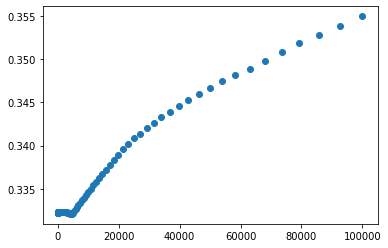

In [39]:
plt.scatter(df_res2.loc['params', 'Lasso'], df_res2.loc['mean_test_score', 'Lasso'])

In [223]:
import dill
file = open(os.getcwd()+'/P4_df_res_new.pkl', 'wb')
dill.dump(df_res, file)

In [193]:
file = open(os.getcwd()+'/P4_df_res.pkl', 'rb')
df_res_old = dill.load(file)
df_res_old

,LinearRegression,Ridge,Lasso,ElasticNet
MAE,4864185.48,4847548.82,4588717.18,4666109.08
MSE,87193181080086.47,85560664257249.94,81583975413283.94,123910699520558.81
RMSE,9337728.90,9249900.77,9032384.81,11131518.29
RMSLE,1.36,1.14,1.10,1.09
R2,0.60,0.60,0.62,0.43
best_params,NaN,1.65,100000.00,2.24
params,NaN,"(1e-05, 1.080052374516254e-05, 1.1665131316981961e-05, 1.2598952777950285e-05, 1.360752886424333...","(1e-05, 1.080052374516254e-05, 1.1665131316981961e-05, 1.2598952777950285e-05, 1.360752886424333...","(1e-05, 1.080052374516254e-05, 1.1665131316981961e-05, 1.2598952777950285e-05, 1.360752886424333..."
mean_test_score,NaN,"(0.41712443819602407, 0.4171244395377226, 0.4171244409863252, 0.4171244425509479, 0.417124444240...","(0.3322165532435487, 0.3322165532444113, 0.33221655324534966, 0.33221655324635657, 0.33221655324...","(0.3297339622235056, 0.32973212585280265, 0.3297301568270762, 0.3297280467465893, 0.329725786863..."
std_test_score,NaN,"(0.16162832066338848, 0.16162831966027014, 0.16162831857707294, 0.16162831740713984, 0.161628316...","(0.07983780789207172, 0.07983780789194952, 0.07983780789181807, 0.07983780789167455, 0.079837807...","(0.2076049228991003, 0.20760331256901451, 0.20760157598032197, 0.20759970358697233, 0.2075976851..."
mean_fit_time,NaN,"(0.904454231262207, 0.8910851001739502, 0.899876880645752, 0.9013097763061524, 0.883906555175781...","(0.9297696590423584, 0.9267526149749756, 0.9208259105682373, 0.9257245063781738, 0.9239766597747...","(1.1550892829895019, 1.1547897338867188, 1.1533389568328858, 1.1534400939941407, 1.1148958206176..."


In [ ]:
# cross_val_score(pipe, df_X, df_y1, cv=5, scoring='r2').mean()

In [ ]:
# ANCIENNE BOUCLE

alphas = np.logspace(-5,5,300) # np.logspace(-5,5,200)
l1_ratio = [0,0.15,0.3,0.45,0.6,0.75,1]

for name_reg, reg in zip(['Ridge', 'Lasso', 'ElasticNet'],
                         [Ridge(), Lasso(), ElasticNet()]):
    

    pipe = make_pipeline(column_trans, reg)
    gscv = GridSearchCV(pipe,
                        param_grid={name_reg.lower()+'__alpha': alphas},
                        cv=kf, verbose=0)
    gscv.fit(X_tr,y1_tr)

    y_pr = gscv.predict(X_te)
    res=scores(name_reg, X_te, y1_te, y_pr)

    df_res.insert(value=res.astype('object'), loc=df_res.shape[1],
                    column=res.name, allow_duplicates=False)
    
    df_res.loc['best_params', name_reg] = gscv.best_params_[name_reg.lower()+'__alpha']
    df_res.loc['params', name_reg] = tuple(gscv.cv_results_['param_'+ name_reg.lower() +'__alpha'].tolist())
    df_res.loc['params', name_reg] = tuple(gscv.cv_results_['param_'+ name_reg.lower() +'__alpha'].tolist())

    new_rows = ['mean_test_score', 'std_test_score',
                'mean_fit_time', 'std_fit_time',
                'mean_score_time', 'std_score_time']
    for r in new_rows:
        df_res.loc[r, name_reg] = tuple(gscv.cv_results_[r])